<a href="https://colab.research.google.com/github/CrzyDinesh/crop-yield-prediction-/blob/main/LHDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.19.0
[]


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
import cv2
import numpy as np
import os
import random

IMG_SIZE = 224
NUM_IMAGES = 200

BASE_DIR = "data"
HS_DIR = os.path.join(BASE_DIR, "HS")
NHS_DIR = os.path.join(BASE_DIR, "NHS")

os.makedirs(HS_DIR, exist_ok=True)
os.makedirs(NHS_DIR, exist_ok=True)

def draw_layout(is_hotspot=True):
    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

    if is_hotspot:
        x = random.randint(40, 60)
        cv2.rectangle(img, (x, 20), (x+15, 200), 255, -1)
        cv2.rectangle(img, (x+20, 20), (x+35, 200), 255, -1)
    else:
        x = random.randint(40, 60)
        cv2.rectangle(img, (x, 20), (x+15, 200), 255, -1)
        cv2.rectangle(img, (x+60, 20), (x+75, 200), 255, -1)

    return img

for i in range(NUM_IMAGES):
    cv2.imwrite(f"{HS_DIR}/HS_{i}.png", draw_layout(True))
    cv2.imwrite(f"{NHS_DIR}/NHS_{i}.png", draw_layout(False))

print("Dataset generated successfully")


Dataset generated successfully


In [14]:
!ls


data  sample_data


In [16]:
!ls data


HS  NHS


In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

IMG_SIZE = 224

images = []
labels = []

# 0 = NHS, 1 = HS
for label, folder in enumerate(["NHS", "HS"]):
    folder_path = f"data/{folder}"
    for file in os.listdir(folder_path):
        img = load_img(
            os.path.join(folder_path, file),
            color_mode="grayscale",
            target_size=(IMG_SIZE, IMG_SIZE)
        )
        img = img_to_array(img)
        images.append(img)
        labels.append(label)

images = np.array(images) / 255.0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Dataset loaded successfully")
print("Train:", X_train.shape)
print("Test :", X_test.shape)


Dataset loaded successfully
Train: (320, 224, 224, 1)
Test : (80, 224, 224, 1)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_test, y_test)
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 1.6921e-11 - val_accuracy: 1.0000 - val_loss: 5.4709e-17
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 3.8359e-10 - val_accuracy: 1.0000 - val_loss: 5.4290e-17
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 2.6976e-11 - val_accuracy: 1.0000 - val_loss: 5.4235e-17
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 7.8881e-10 - val_accuracy: 1.0000 - val_loss: 5.4184e-17
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 7.4863e-10 - val_accuracy: 1.0000 - val_loss: 5.3973e-17
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 7.2724e-12 - val_accuracy: 1.0000 - val_loss: 5.3937e-17
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 2.9449e-08 - val_accuracy: 1.0000 - val_loss: 4.3505e-17
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - ac

In [24]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

IMG_SIZE = 224

def load_gan_images(folder):
    images = []
    for file in os.listdir(folder):
        img = load_img(
            os.path.join(folder, file),
            color_mode="grayscale",
            target_size=(IMG_SIZE, IMG_SIZE)
        )
        img = img_to_array(img)
        images.append(img)
    images = np.array(images)
    images = (images / 127.5) - 1   # GAN normalization [-1,1]
    return images

HS_images = load_gan_images("data/HS")
NHS_images = load_gan_images("data/NHS")

print("HS:", HS_images.shape)
print("NHS:", NHS_images.shape)


HS: (200, 224, 224, 1)
NHS: (200, 224, 224, 1)


In [26]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU
from tensorflow.keras.models import Model

def build_generator():
    inputs = Input(shape=(224,224,1))

    x = Conv2D(64, 4, strides=2, padding="same")(inputs)
    x = ReLU()(x)

    x = Conv2D(128, 4, strides=2, padding="same")(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, 4, strides=2, padding="same")(x)
    x = ReLU()(x)

    outputs = Conv2DTranspose(1, 4, strides=2, padding="same", activation="tanh")(x)

    return Model(inputs, outputs)

generator = build_generator()
generator.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 112, 112, 64)   │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 112, 112, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 224, 224, 1)    │         1,025 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense

def build_discriminator():
    inputs = Input(shape=(224,224,1))

    x = Conv2D(64, 4, strides=2, padding="same")(inputs)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, 4, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

discriminator = build_discriminator()
discriminator.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 64)   │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │       401,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,697 (2.04 MB)

 Trainable params: 533,697 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)


In [33]:
EPOCHS = 5   # keep small for understanding
BATCH_SIZE = 1

@tf.function
def train_step(real_hs, real_nhs):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_nhs = generator(real_hs, training=True)

        real_output = discriminator(real_nhs, training=True)
        fake_output = discriminator(fake_nhs, training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss = (
            loss_fn(tf.ones_like(real_output), real_output) +
            loss_fn(tf.zeros_like(fake_output), fake_output)
        )

    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

for epoch in range(EPOCHS):
    for i in range(len(HS_images)):
        train_step(
            HS_images[i:i+1],
            NHS_images[i:i+1]
        )
    print(f"Epoch {epoch+1}/{EPOCHS} completed")


Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed


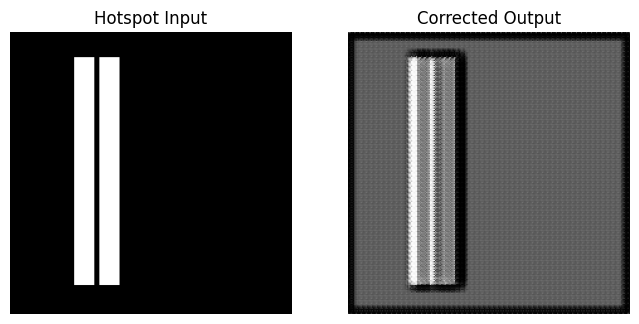

In [39]:
import matplotlib.pyplot as plt

test_img = HS_images[50:61]
generated_img = generator(test_img, training=False)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Hotspot Input")
plt.imshow(test_img[0,:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Corrected Output")
plt.imshow((generated_img[0,:,:,0]+1)/2, cmap="gray")
plt.axis("off")

plt.show()


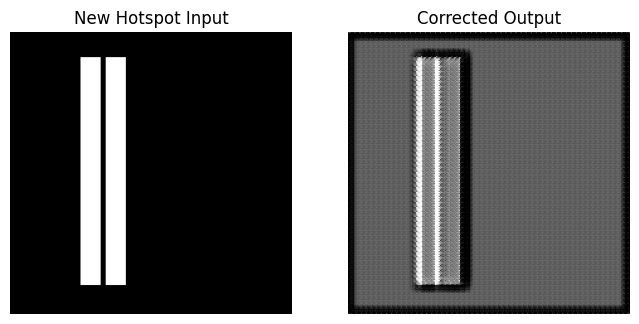

In [40]:
# Give another input from dataset
test_img = HS_images[15:16]   # change number: 0, 5, 10, 20 etc.

generated_img = generator(test_img, training=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("New Hotspot Input")
plt.imshow(test_img[0,:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Corrected Output")
plt.imshow((generated_img[0,:,:,0]+1)/2, cmap="gray")
plt.axis("off")

plt.show()


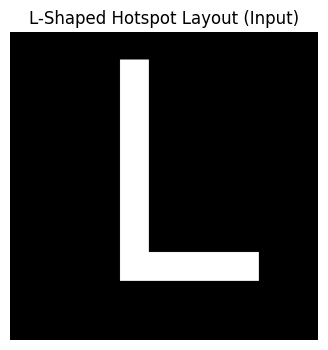

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 224
img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

# Vertical line
cv2.rectangle(img, (80, 20), (100, 180), 255, -1)

# Horizontal line very close (corner hotspot)
cv2.rectangle(img, (100, 160), (180, 180), 255, -1)

plt.figure(figsize=(4,4))
plt.title("L-Shaped Hotspot Layout (Input)")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


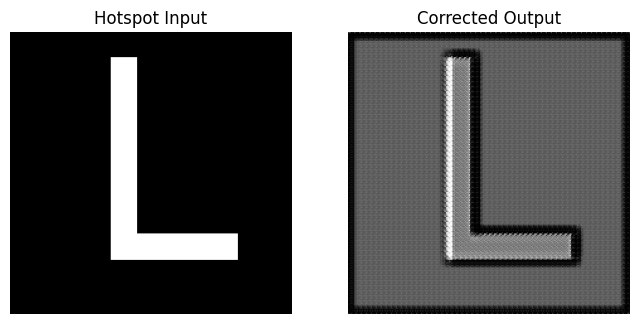

In [46]:
# Prepare for GAN
test_img = img.astype(np.float32)
test_img = (test_img / 127.5) - 1
test_img = np.expand_dims(test_img, axis=(0, -1))

corrected = generator(test_img, training=False)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Hotspot Input")
plt.imshow(test_img[0,:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Corrected Output")
plt.imshow((corrected[0,:,:,0]+1)/2, cmap="gray")
plt.axis("off")

plt.show()


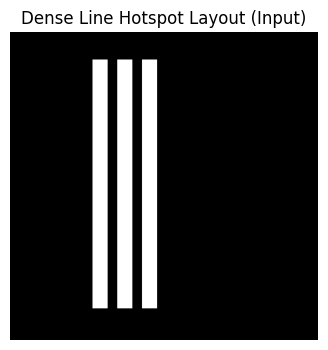

In [47]:
img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

for x in range(60, 100, 18):   # very tight spacing
    cv2.rectangle(img, (x, 20), (x+10, 200), 255, -1)

plt.figure(figsize=(4,4))
plt.title("Dense Line Hotspot Layout (Input)")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


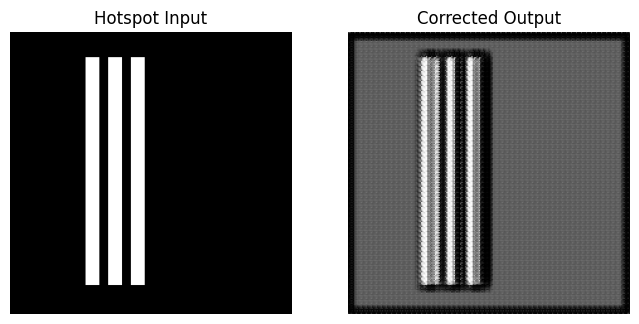

In [49]:
# Prepare for GAN
test_img = img.astype(np.float32)
test_img = (test_img / 127.5) - 1
test_img = np.expand_dims(test_img, axis=(0, -1))

corrected = generator(test_img, training=False)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Hotspot Input")
plt.imshow(test_img[0,:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Corrected Output")
plt.imshow((corrected[0,:,:,0]+1)/2, cmap="gray")
plt.axis("off")

plt.show()


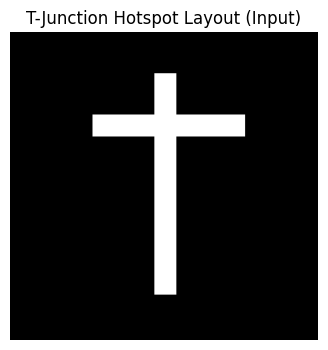

In [50]:
img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

# Vertical stem
cv2.rectangle(img, (105, 30), (120, 190), 255, -1)

# Horizontal top bar
cv2.rectangle(img, (60, 60), (170, 75), 255, -1)

plt.figure(figsize=(4,4))
plt.title("T-Junction Hotspot Layout (Input)")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


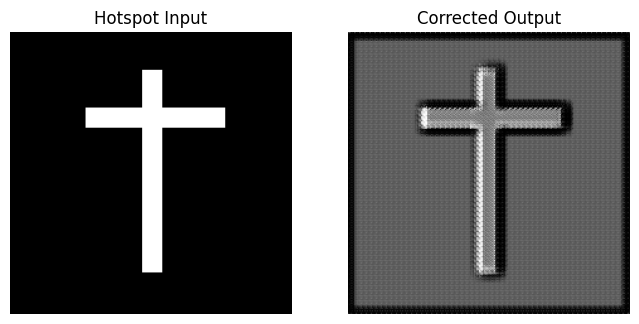

In [52]:
# Prepare for GAN
test_img = img.astype(np.float32)
test_img = (test_img / 127.5) - 1
test_img = np.expand_dims(test_img, axis=(0, -1))

corrected = generator(test_img, training=False)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Hotspot Input")
plt.imshow(test_img[0,:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Corrected Output")
plt.imshow((corrected[0,:,:,0]+1)/2, cmap="gray")
plt.axis("off")

plt.show()


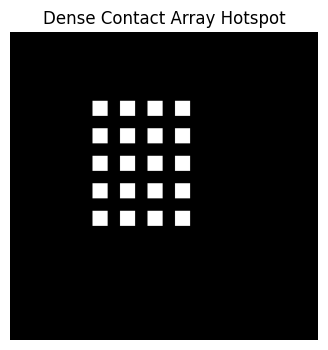

In [53]:
img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

for y in range(50, 150, 20):
    for x in range(60, 140, 20):
        cv2.rectangle(img, (x, y), (x+10, y+10), 255, -1)

plt.figure(figsize=(4,4))
plt.title("Dense Contact Array Hotspot")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


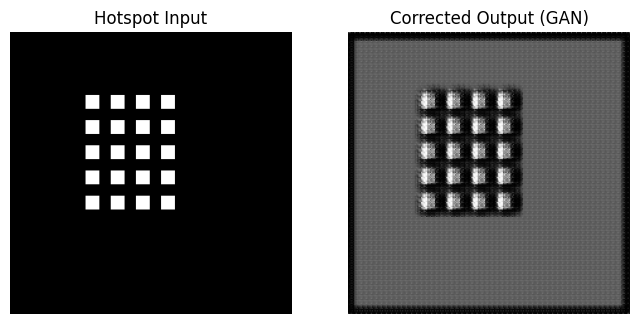

In [55]:
# Prepare image for GAN
test_img = img.astype(np.float32)
test_img = (test_img / 127.5) - 1
test_img = np.expand_dims(test_img, axis=(0, -1))

corrected = generator(test_img, training=False)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Hotspot Input")
plt.imshow(test_img[0,:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Corrected Output (GAN)")
plt.imshow((corrected[0,:,:,0] + 1) / 2, cmap="gray")
plt.axis("off")

plt.show()


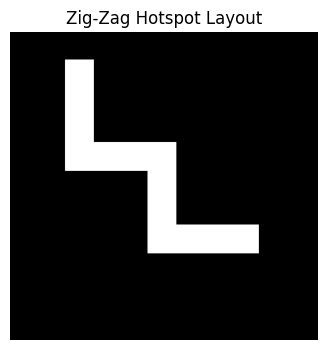

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 224
img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

# Zig-zag pattern
cv2.rectangle(img, (40, 20), (60, 100), 255, -1)
cv2.rectangle(img, (60, 80), (120, 100), 255, -1)
cv2.rectangle(img, (100, 80), (120, 160), 255, -1)
cv2.rectangle(img, (120, 140), (180, 160), 255, -1)

plt.figure(figsize=(4,4))
plt.title("Zig-Zag Hotspot Layout")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


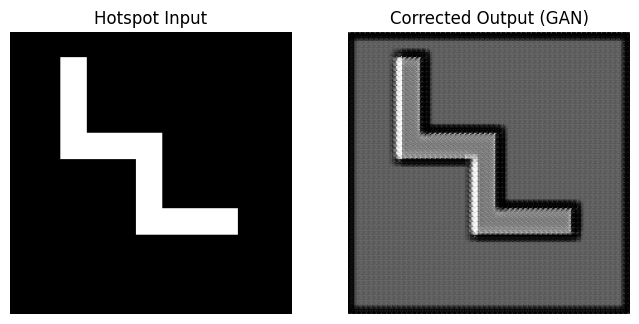

In [58]:
# Prepare image for GAN
test_img = img.astype(np.float32)
test_img = (test_img / 127.5) - 1
test_img = np.expand_dims(test_img, axis=(0, -1))

corrected = generator(test_img, training=False)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Hotspot Input")
plt.imshow(test_img[0,:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Corrected Output (GAN)")
plt.imshow((corrected[0,:,:,0] + 1) / 2, cmap="gray")
plt.axis("off")

plt.show()
